# Прогнозирование большого количества рядов

In [1]:
import pickle
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)

 1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!

In [2]:
def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data

In [3]:
data = load_pickle('all_regions.pkl')
data

array([[ 87.,  92., 108., ..., 151., 106.,  85.],
       [146., 184., 165., ..., 162., 168., 130.],
       [ 70.,  93.,  55., ..., 145., 103.,  86.],
       ...,
       [106.,  87.,  39., ..., 213., 206., 173.],
       [ 22.,   0.,   0., ..., 142., 146., 119.],
       [ 71.,  44.,   1., ...,   1.,   0.,   0.]])

In [4]:
geo_json_data = json.load(open('regions_left.json')) # только соответствующие условию регионы

In [5]:
regions = []
for i in geo_json_data['features']:
    regions.append(int(i['id'])+1)

In [6]:
dates = pd.date_range('2014-01-01 00:00:00', periods=data.shape[1], freq='H')
df_full = pd.DataFrame(data.transpose(), index=dates, columns=regions)
df_full.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2014-01-01 00:00:00,87.0,146.0,70.0,113.0,367.0,645.0,589.0,799.0,948.0,321.0,...,9.0,0.0,5.0,89.0,10.0,35.0,9.0,106.0,22.0,71.0
2014-01-01 01:00:00,92.0,184.0,93.0,153.0,539.0,604.0,490.0,635.0,667.0,225.0,...,24.0,0.0,3.0,22.0,2.0,5.0,0.0,87.0,0.0,44.0
2014-01-01 02:00:00,108.0,165.0,55.0,151.0,443.0,571.0,465.0,499.0,455.0,124.0,...,27.0,0.0,3.0,23.0,1.0,1.0,0.0,39.0,0.0,1.0
2014-01-01 03:00:00,77.0,108.0,32.0,112.0,372.0,533.0,442.0,370.0,307.0,101.0,...,57.0,0.0,0.0,3.0,2.0,1.0,0.0,5.0,1.0,0.0
2014-01-01 04:00:00,47.0,79.0,22.0,77.0,213.0,383.0,296.0,319.0,261.0,87.0,...,38.0,0.0,1.0,9.0,1.0,8.0,0.0,29.0,1.0,18.0


In [7]:
df_full.shape

(21888, 102)

уменьшим количество наблюдений для более удобной работы

In [8]:
df = df_full.loc['2016-04-01 00:00:00':'2016-04-30 23:00:00']

2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.



In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
df_new = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index = df.index)
df_new.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-04-01 00:00:00,-0.515019,-1.031047,-0.999806,-0.047065,-0.243865,0.090873,1.221386,1.180456,1.179130,0.316922,...,-0.234588,-0.924545,-0.790592,-0.311499,-0.923175,0.237511,0.515829,0.486176,0.854275,0.858703
2016-04-01 01:00:00,-1.035163,-1.163537,-1.246812,-0.583333,-1.050387,-0.414204,0.091729,0.367868,0.705762,-0.238034,...,0.569713,-0.924545,-0.263775,-1.358649,-1.181507,-0.397122,0.515829,0.355165,-0.676341,0.100493
2016-04-01 02:00:00,-1.357157,-1.416473,-1.296214,-1.247283,-1.369013,-0.989431,-0.761278,-0.298746,0.541287,-1.153711,...,0.770789,-0.924545,-1.317410,-1.378916,-1.295476,-1.237581,-1.006810,-1.465878,-1.173792,-1.551323
2016-04-01 03:00:00,-1.456232,-1.585097,-1.444418,-1.247283,-1.627897,-1.024506,-1.377979,-0.955629,0.304603,-1.195332,...,-0.234588,-0.924545,-0.790592,-1.378916,-1.303074,-1.546321,-1.260583,-1.727899,-1.173792,-1.713796
2016-04-01 04:00:00,-1.431464,-1.536918,-1.444418,-1.349429,-1.617940,-1.206895,-1.464432,-1.125932,-0.734400,-1.625423,...,0.569713,-0.849548,-0.527184,-1.358649,-1.287878,-1.529169,-1.260583,-1.675495,-1.173792,-1.713796


3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.



In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

Для начала проведем иерархическую кластеризацию и оценим результат

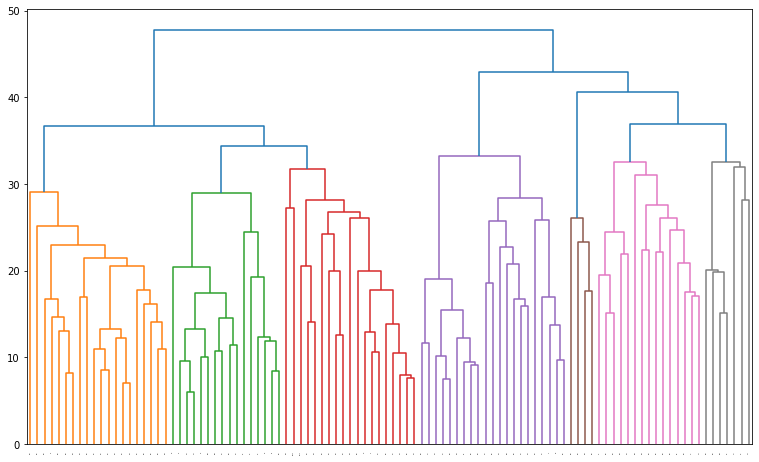

In [12]:
mergings1 = linkage(df_new.transpose().to_numpy(), method='complete') 
fig = plt.figure(figsize=(13, 8))
result = dendrogram(mergings1,leaf_font_size=2) 
plt.show()

В результате иерархической кластеризации было выделено 7 класеров

Чтобы убедиться в полученном результате построим график "локтя"

In [13]:
# Объект, в котором будет хранится информация о последовательном слиянии кластеров
link = linkage(df_new.transpose(), 'ward', 'euclidean')

In [14]:
dist = link[:, 2]

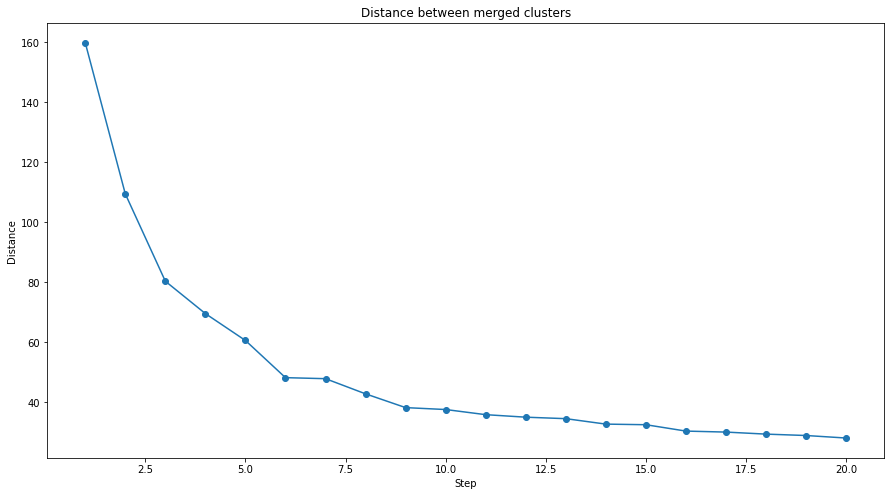

In [15]:
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs[:20], dist_rev[:20], marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.show()

Из графика видно, что оптимальное число кластеров 6-7, так как после этих значений межкластерное расстояние наченает уменьшаться гораздо медленнее 

4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).



Добавим метки кластеров в исходный dataframe

In [16]:
df_tr = df_new.transpose()
df_tr.head()

,2016-04-01 00:00:00,2016-04-01 01:00:00,2016-04-01 02:00:00,2016-04-01 03:00:00,2016-04-01 04:00:00,2016-04-01 05:00:00,2016-04-01 06:00:00,2016-04-01 07:00:00,2016-04-01 08:00:00,2016-04-01 09:00:00,...,2016-04-30 14:00:00,2016-04-30 15:00:00,2016-04-30 16:00:00,2016-04-30 17:00:00,2016-04-30 18:00:00,2016-04-30 19:00:00,2016-04-30 20:00:00,2016-04-30 21:00:00,2016-04-30 22:00:00,2016-04-30 23:00:00
1075,-0.515019,-1.035163,-1.357157,-1.456232,-1.431464,-1.481001,-1.258082,-0.589325,0.079432,-0.193025,...,1.763709,1.937091,2.358160,1.862785,2.234316,1.342640,0.995877,0.599577,0.822496,0.624345
1076,-1.031047,-1.163537,-1.416473,-1.585097,-1.536918,-1.356250,-0.778112,0.161364,0.920170,0.775636,...,2.136670,1.907824,0.884037,1.124928,0.992438,0.823814,0.811769,0.173408,-0.525176,-0.272240
1077,-0.999806,-1.246812,-1.296214,-1.444418,-1.444418,-1.296214,-0.719865,0.893913,1.783137,0.877446,...,0.860979,0.910380,0.334031,0.317564,0.531636,0.877446,0.119958,0.268162,-0.110581,-0.472858
1125,-0.047065,-0.583333,-1.247283,-1.247283,-1.349429,-1.272820,-0.685479,0.208300,0.872250,0.310446,...,0.565812,0.565812,0.157227,0.719031,1.076543,0.821177,0.974397,1.178689,0.795641,0.438129
1126,-0.243865,-1.050387,-1.369013,-1.627897,-1.617940,-1.319228,-0.801461,-0.452963,0.413301,0.283859,...,0.931068,0.911154,0.682142,1.359222,1.428922,1.488664,0.941026,1.219823,0.214160,0.881283


In [17]:
df_tr['cluster'] = fcluster(link, 50, criterion='distance')

В качестве типичного ряда кластера, выберем усредненный ряд из всех регионов, попавших в данный кластер 

In [18]:
df_cluser = df_tr.groupby('cluster').mean()

In [19]:
df_cluser

,2016-04-01 00:00:00,2016-04-01 01:00:00,2016-04-01 02:00:00,2016-04-01 03:00:00,2016-04-01 04:00:00,2016-04-01 05:00:00,2016-04-01 06:00:00,2016-04-01 07:00:00,2016-04-01 08:00:00,2016-04-01 09:00:00,...,2016-04-30 14:00:00,2016-04-30 15:00:00,2016-04-30 16:00:00,2016-04-30 17:00:00,2016-04-30 18:00:00,2016-04-30 19:00:00,2016-04-30 20:00:00,2016-04-30 21:00:00,2016-04-30 22:00:00,2016-04-30 23:00:00
cluster,,,,,,,,,,,,,,,,,,,,,
1,-0.881914,-1.122034,-1.325908,-1.423173,-1.453786,-1.209609,-0.474788,0.753706,1.245893,0.806456,...,0.719847,0.640570,0.486868,0.674817,0.926696,0.985465,0.447449,0.154060,0.124757,0.115852
2,0.122742,-0.677035,-1.172795,-1.403795,-1.496563,-1.446797,-0.855953,-0.069065,0.454361,0.332577,...,0.387631,0.401983,0.154983,0.495876,0.896030,1.122143,0.825735,0.942213,1.159138,1.232034
3,-0.064366,-0.496853,-1.261274,-1.314200,-1.269857,-1.051921,-0.629113,-0.293077,-0.104753,-0.278003,...,0.224744,0.416170,0.145398,0.687057,-0.002627,0.031326,0.070039,0.253925,0.081863,-0.092975
4,0.839121,0.445973,0.100127,-0.306043,-0.650759,-0.840734,-0.530268,-0.218228,-0.138811,-0.158350,...,0.192427,0.070518,-0.019226,0.240309,0.476993,0.725995,0.684738,1.255641,1.916512,2.725109
5,0.014074,-0.331361,-0.818088,-0.946969,-0.832224,-0.662911,0.618057,2.454428,2.181148,0.274640,...,0.209106,-0.080941,0.138872,0.481357,0.657007,0.462526,0.319469,0.762641,0.429257,1.290473
6,-0.130864,-0.187177,-0.104009,-0.438237,0.369551,0.055610,0.944081,1.359332,1.199029,0.376687,...,-0.314708,-0.046932,-0.441991,-0.173203,-0.221939,-0.368975,-0.253959,-0.156864,-0.296065,0.652196


Изобразим 6 полученных рядов:

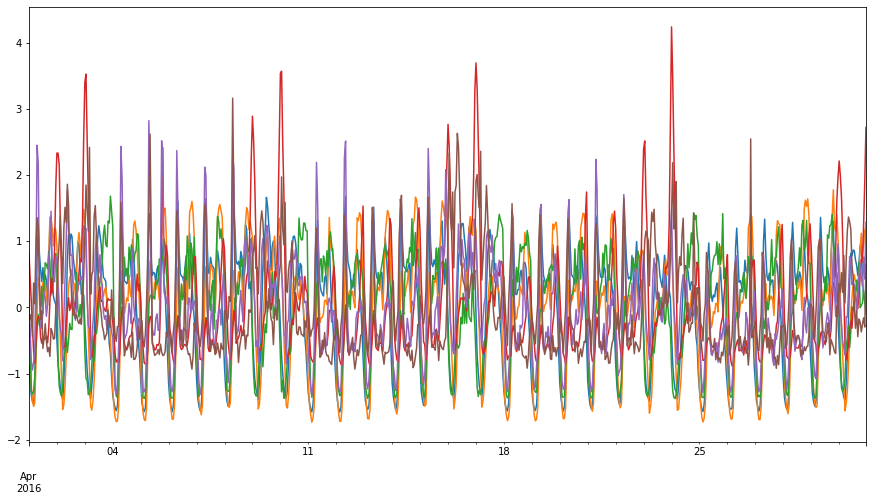

In [20]:
for i in range(0,6):
    df_cluser.iloc[i].plot()
plt.show()

5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!



In [42]:
df_transp = df_cluser.transpose()
df_transp.index = pd.DatetimeIndex(df_transp.index, freq='H')
df_transp.head()

cluster,1,2,3,4,5,6
2016-04-01 00:00:00,-0.881914,0.122742,-0.064366,0.839121,0.014074,-0.130864
2016-04-01 01:00:00,-1.122034,-0.677035,-0.496853,0.445973,-0.331361,-0.187177
2016-04-01 02:00:00,-1.325908,-1.172795,-1.261274,0.100127,-0.818088,-0.104009
2016-04-01 03:00:00,-1.423173,-1.403795,-1.314200,-0.306043,-0.946969,-0.438237
2016-04-01 04:00:00,-1.453786,-1.496563,-1.269857,-0.650759,-0.832224,0.369551


Создадим экзогенные признаки

In [43]:
exog = pd.DataFrame()
r = pd.DataFrame()

In [44]:
m = 169
n = len(df_transp)
for i in range(1, m):
    sin = "sin_" + str(i)
    cos = "cos_" + str(i)
    exog[sin] = np.sin(2*np.pi*i*np.arange(1, n+1)/168.0)
    exog[cos] = np.cos(2*np.pi*i*np.arange(1, n+1)/168.0)

Обучим линейную регрессию и посмотрим на остатки

In [45]:
from sklearn.linear_model import LinearRegression

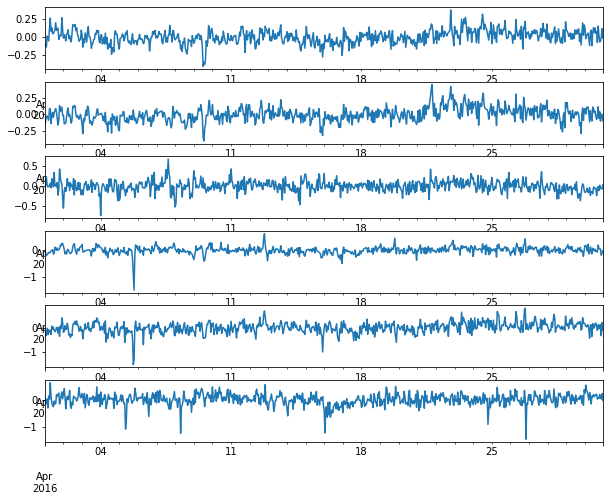

In [46]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(10,8))
for i in range (1,7):
    y = df_transp[i]
    model = LinearRegression()
    model.fit(exog.values, y)
    predictions = model.predict(exog.values)
    r[i] = predictions - y
    r[i].plot(ax=ax[i-1])
    

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

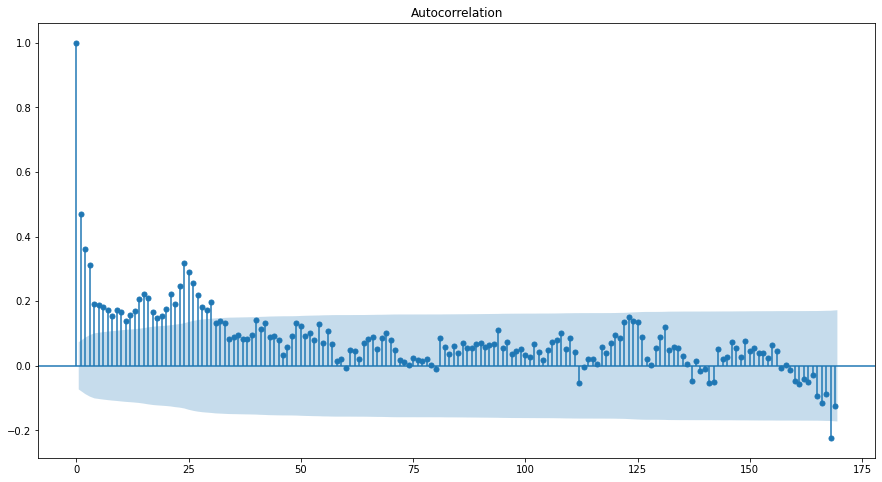

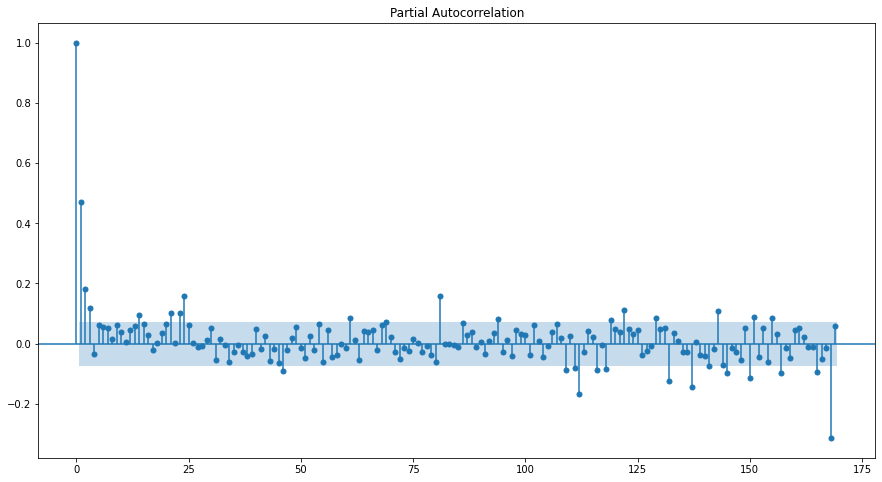

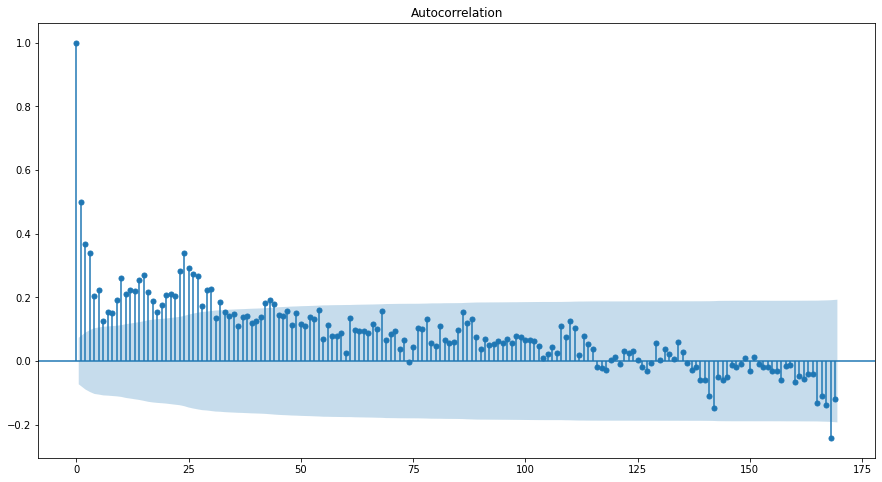

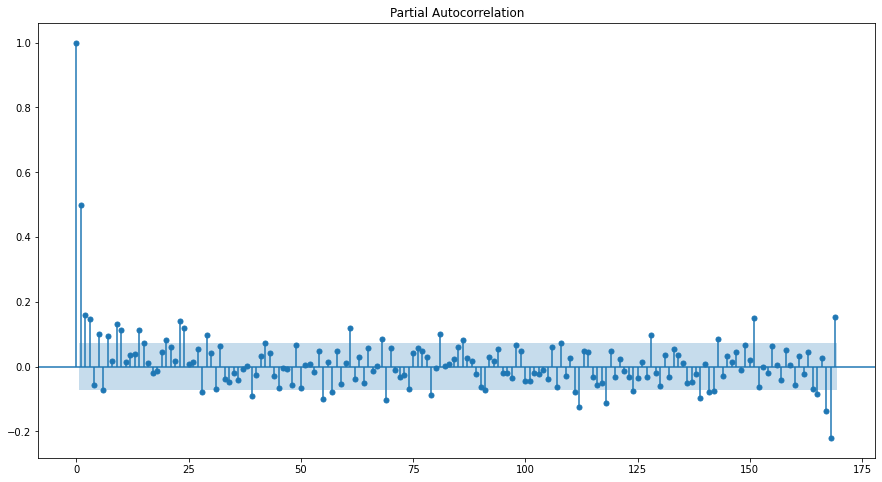

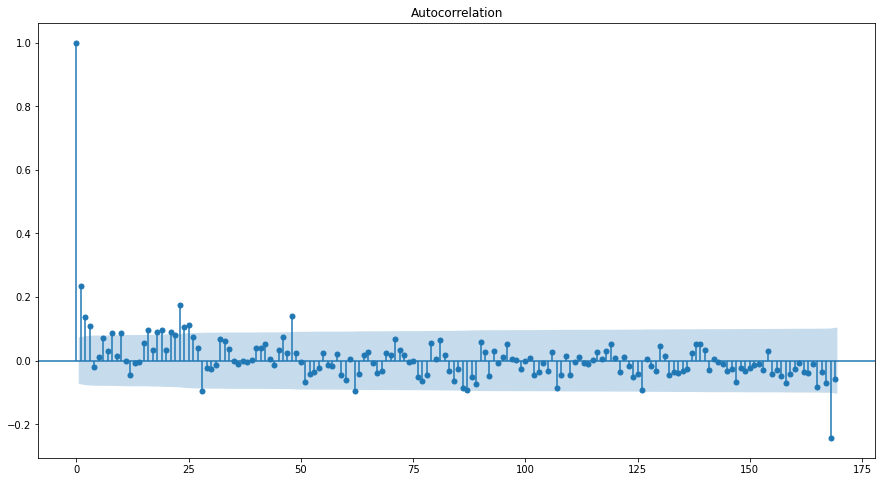

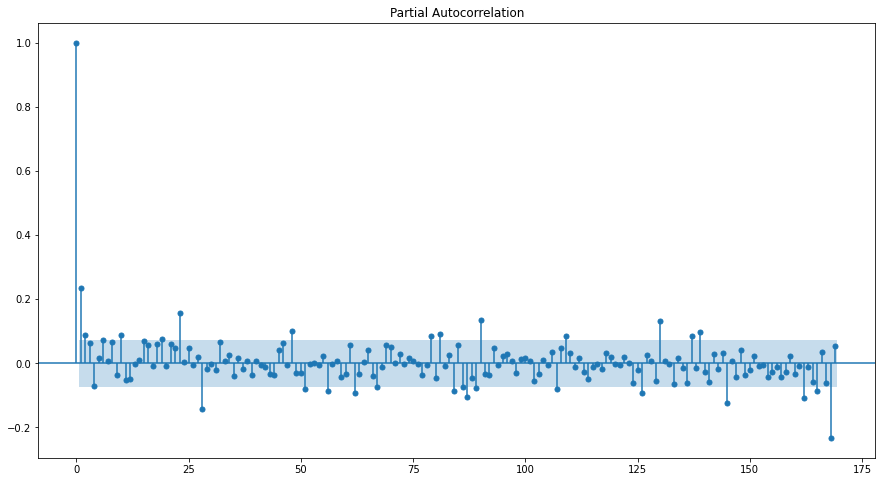

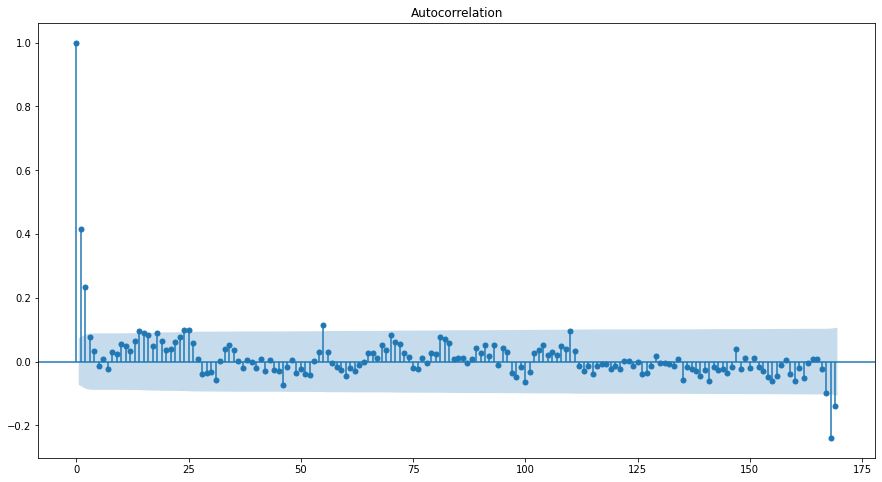

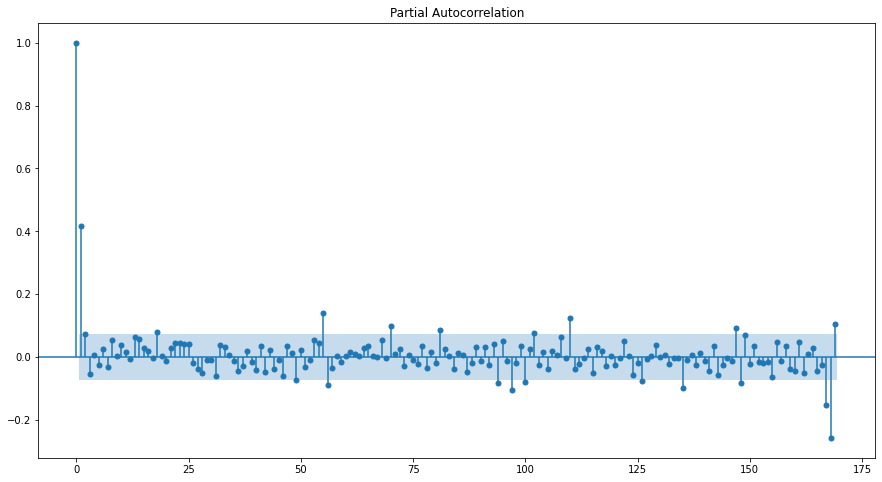

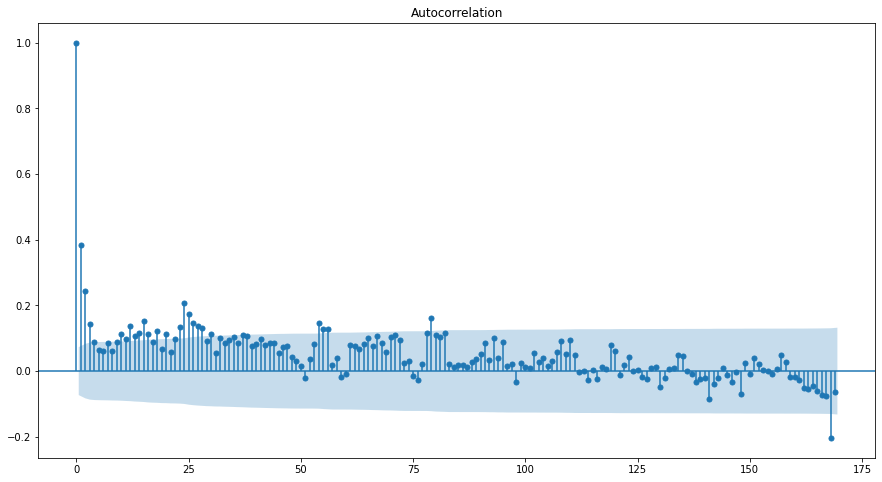

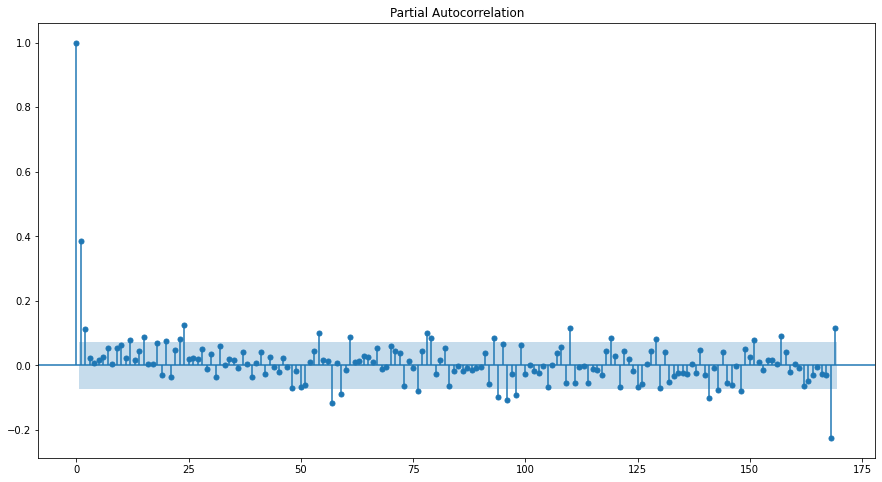

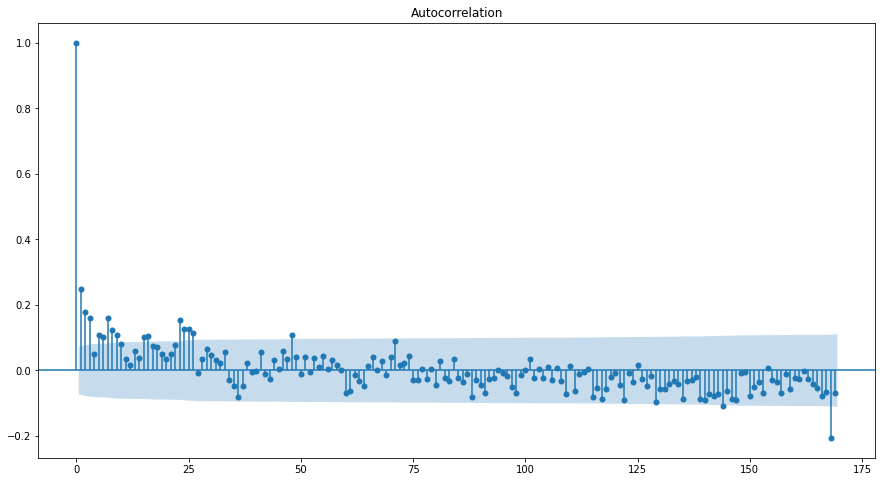

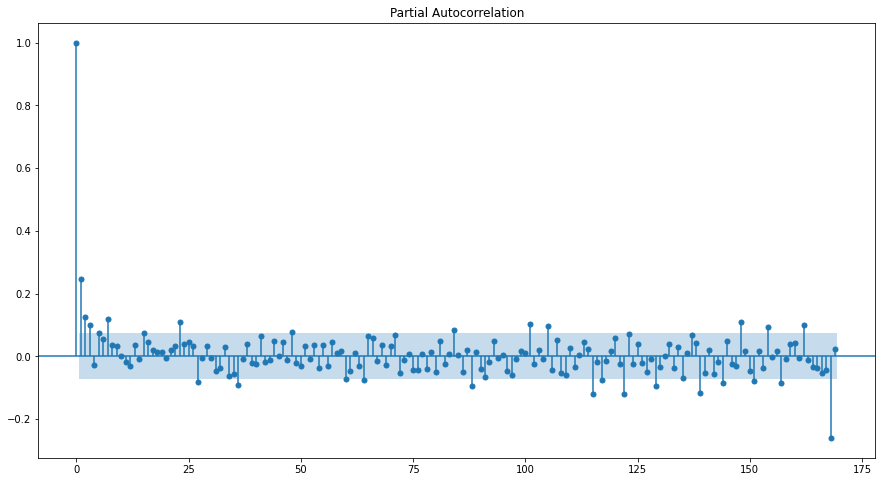

In [48]:
for i in range (1,7):
    plot_acf(r[i].dropna(), lags=169)
    plot_pacf(r[i].dropna(), lags=169)
    plt.show()

In [56]:
import warnings
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [57]:
q = 6 # последний значимый лаг автокорреляции
Q = 1 # последний значимый сезонный лаг автокорреляции, деленный на период сезонности 
p = 3 # последний значимый лаг частичной автокорреляции
P = 1 # последний значимый сезонный лаг частичной автокорреляции, деленный на период сезонности 

qs = range(4, 7)
ps = range(3, 5)
Ps = range(1, 2)
Qs = range(1, 2)

In [58]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

6

__Подбор параметров для первого кластера:__

In [59]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(df_transp[1], 
                expg = exog,
                order=(param[0], 0, param[1]), 
                seasonal_order=(param[2], 0, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1min 9s, sys: 5.31 s, total: 1min 15s
Wall time: 42.2 s


In [60]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters        aic
1  (3, 5, 1, 1)  29.945909
2  (3, 6, 1, 1)  32.186680
5  (4, 6, 1, 1)  36.722602
4  (4, 5, 1, 1)  39.648779
3  (4, 4, 1, 1)  39.713629


__Подбор параметров для второго кластера:__

In [79]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(df_transp[2], 
                expg = exog,
                order=(param[0], 0, param[1]), 
                seasonal_order=(param[2], 0, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1min 4s, sys: 4.67 s, total: 1min 9s
Wall time: 39.9 s


In [80]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters         aic
4  (4, 5, 1, 1) -473.496419
0  (3, 4, 1, 1) -471.803773
5  (4, 6, 1, 1) -470.438279
3  (4, 4, 1, 1) -463.000344
1  (3, 5, 1, 1) -459.914008


__Подбор параметров для 3 кластера:__

In [81]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(df_transp[3], 
                expg = exog,
                order=(param[0], 0, param[1]), 
                seasonal_order=(param[2], 0, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1min 28s, sys: 6.37 s, total: 1min 34s
Wall time: 52 s


In [82]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters        aic
0  (3, 4, 1, 1) -50.757617
1  (3, 5, 1, 1) -49.659247
2  (3, 6, 1, 1) -43.215264
5  (4, 6, 1, 1) -41.562506
4  (4, 5, 1, 1) -37.029254


__Подбор параметров для 4 кластера:__

In [83]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(df_transp[4], 
                expg = exog,
                order=(param[0], 0, param[1]), 
                seasonal_order=(param[2], 0, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 58.4 s, sys: 3.88 s, total: 1min 2s
Wall time: 30.9 s


In [84]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters        aic
1  (3, 5, 1, 1)  29.945909
2  (3, 6, 1, 1)  32.186680
5  (4, 6, 1, 1)  36.722602
4  (4, 5, 1, 1)  39.648779
3  (4, 4, 1, 1)  39.713629


__Подбор параметров для 5 кластера:__

In [85]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(df_transp[5], 
                expg = exog,
                order=(param[0], 0, param[1]), 
                seasonal_order=(param[2], 0, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1min 4s, sys: 4.2 s, total: 1min 8s
Wall time: 34.3 s


In [86]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters         aic
5  (4, 6, 1, 1)  506.040697
2  (3, 6, 1, 1)  522.185471
4  (4, 5, 1, 1)  528.214924
1  (3, 5, 1, 1)  533.139588
0  (3, 4, 1, 1)  534.568959


__Подбор параметров для 6 кластера:__

In [87]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(df_transp[6], 
                expg = exog,
                order=(param[0], 0, param[1]), 
                seasonal_order=(param[2], 0, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

LinAlgError: LU decomposition error.

In [88]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters         aic
0  (3, 4, 1, 1)  614.923646
1  (3, 5, 1, 1)  616.794450
2  (3, 6, 1, 1)  652.022541


In [89]:
best_params = [[3, 5, 1, 1], [4, 5, 1, 1], [3, 4, 1, 1], [3, 5, 1, 1], [4, 6, 1, 1], [3, 4, 1, 1]]

__Обучение моделей на оптимальных параметрах:__

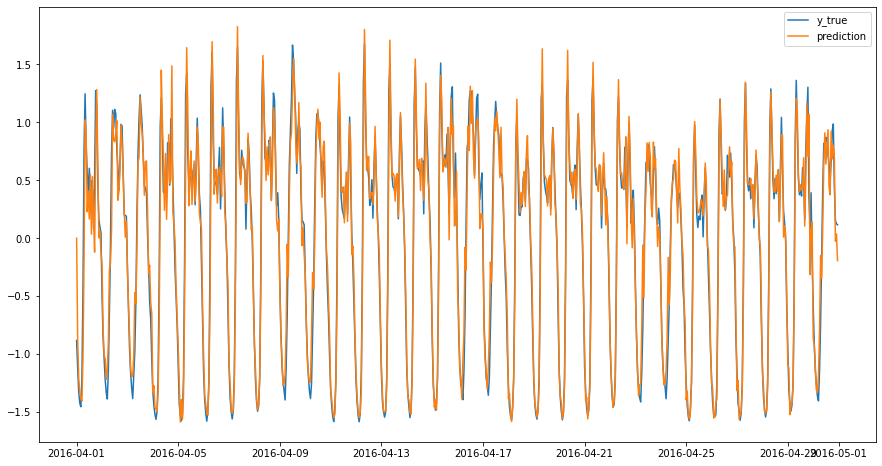

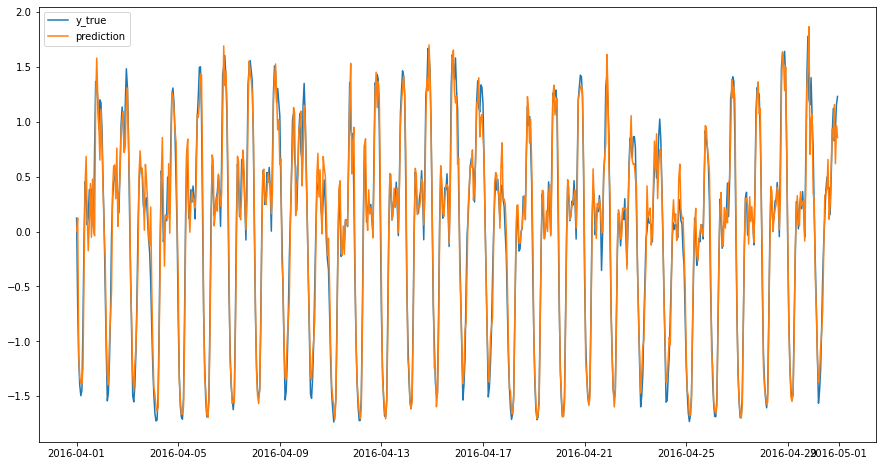

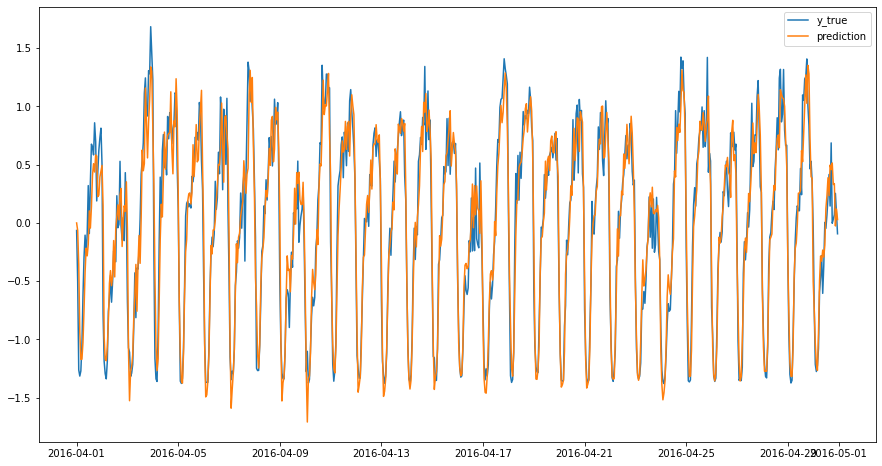

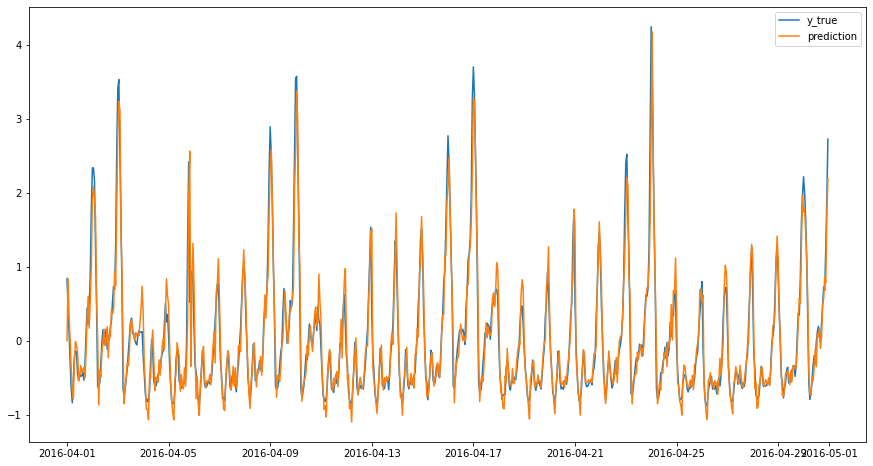

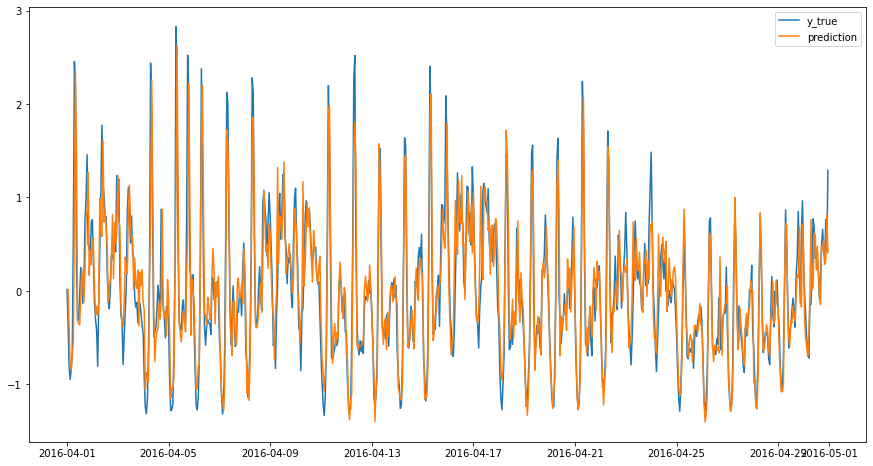

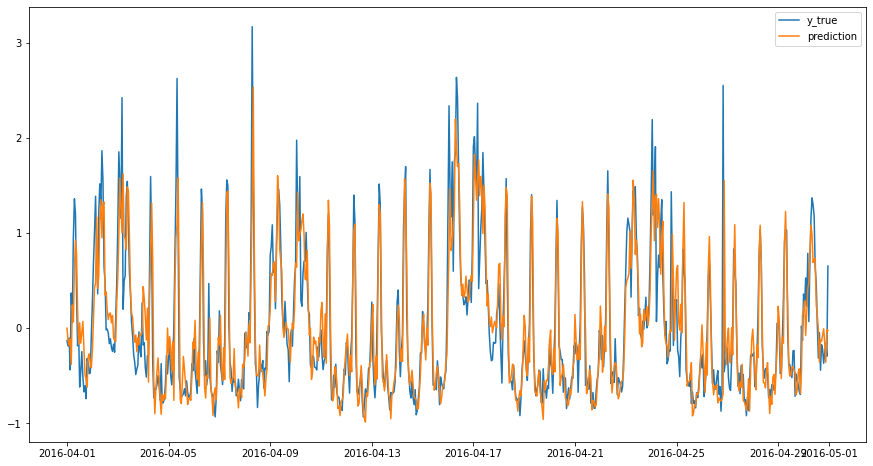

In [90]:
warnings.filterwarnings('ignore')
for i in range(1,7):
    p = best_params[i-1]
    model_sarimax = SARIMAX(df_transp[i], 
                            expg = exog, 
                            order=(p[0], 1, p[1]),
                            seasonal_order=(p[2], 0, p[3], 24)).fit()
    
    plt.plot(df_transp[i], label='y_true')
    plt.plot(model_sarimax.fittedvalues, label='prediction')
    plt.legend()
    plt.show()
warnings.filterwarnings('default')

6. Для каждой из R географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу (R — количество прогнозируемых рядов, 715 — количество перебираемых концов истории):

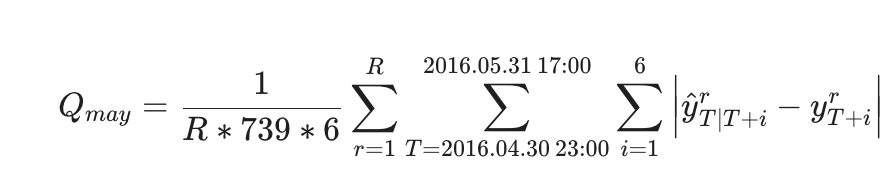

In [104]:
df_true = df_full.loc['2016-04-30 23:00:00':'2016-05-31 17:00:00'].transpose()

In [105]:
df_true.head()

,2016-04-30 23:00:00,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00,2016-05-01 05:00:00,2016-05-01 06:00:00,2016-05-01 07:00:00,2016-05-01 08:00:00,...,2016-05-31 08:00:00,2016-05-31 09:00:00,2016-05-31 10:00:00,2016-05-31 11:00:00,2016-05-31 12:00:00,2016-05-31 13:00:00,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00
1075,92.0,71.0,37.0,10.0,14.0,6.0,8.0,10.0,21.0,17.0,...,74.0,53.0,47.0,78.0,99.0,98.0,124.0,105.0,80.0,84.0
1076,118.0,64.0,39.0,46.0,25.0,20.0,12.0,16.0,48.0,61.0,...,172.0,157.0,154.0,161.0,208.0,177.0,214.0,208.0,156.0,202.0
1077,63.0,52.0,13.0,8.0,6.0,4.0,6.0,7.0,16.0,24.0,...,205.0,131.0,76.0,103.0,91.0,91.0,104.0,69.0,67.0,109.0
1125,86.0,81.0,38.0,34.0,23.0,22.0,5.0,23.0,18.0,15.0,...,97.0,56.0,54.0,51.0,81.0,86.0,96.0,70.0,68.0,109.0
1126,284.0,259.0,121.0,86.0,59.0,64.0,46.0,68.0,69.0,89.0,...,172.0,175.0,155.0,165.0,212.0,201.0,205.0,213.0,168.0,250.0


In [106]:
df_true['cluster'] = df_tr['cluster']

In [107]:
df_true.head()

,2016-04-30 23:00:00,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00,2016-05-01 05:00:00,2016-05-01 06:00:00,2016-05-01 07:00:00,2016-05-01 08:00:00,...,2016-05-31 09:00:00,2016-05-31 10:00:00,2016-05-31 11:00:00,2016-05-31 12:00:00,2016-05-31 13:00:00,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00,cluster
1075,92.0,71.0,37.0,10.0,14.0,6.0,8.0,10.0,21.0,17.0,...,53.0,47.0,78.0,99.0,98.0,124.0,105.0,80.0,84.0,1
1076,118.0,64.0,39.0,46.0,25.0,20.0,12.0,16.0,48.0,61.0,...,157.0,154.0,161.0,208.0,177.0,214.0,208.0,156.0,202.0,1
1077,63.0,52.0,13.0,8.0,6.0,4.0,6.0,7.0,16.0,24.0,...,131.0,76.0,103.0,91.0,91.0,104.0,69.0,67.0,109.0,1
1125,86.0,81.0,38.0,34.0,23.0,22.0,5.0,23.0,18.0,15.0,...,56.0,54.0,51.0,81.0,86.0,96.0,70.0,68.0,109.0,2
1126,284.0,259.0,121.0,86.0,59.0,64.0,46.0,68.0,69.0,89.0,...,175.0,155.0,165.0,212.0,201.0,205.0,213.0,168.0,250.0,2


In [108]:
exog_new = pd.DataFrame()

In [110]:
m = 169
n = len(df_true)
for i in range(1, m):
    sin = "sin_" + str(i)
    cos = "cos_" + str(i)
    exog_new[sin] = np.sin(2*np.pi*i*np.arange(1, n+1)/168.0)
    exog_new[cos] = np.cos(2*np.pi*i*np.arange(1, n+1)/168.0)

In [129]:
exog_new

,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,sin_4,cos_4,sin_5,cos_5,...,sin_164,cos_164,sin_165,cos_165,sin_166,cos_166,sin_167,cos_167,sin_168,cos_168
0,0.037391,0.999301,0.074730,0.997204,0.111964,9.937122e-01,0.149042,0.988831,0.185912,0.982566,...,-0.149042,0.988831,-0.111964,9.937122e-01,-0.074730,0.997204,-0.037391,0.999301,-2.449294e-16,1.0
1,0.074730,0.997204,0.149042,0.988831,0.222521,9.749279e-01,0.294755,0.955573,0.365341,0.930874,...,-0.294755,0.955573,-0.222521,9.749279e-01,-0.149042,0.988831,-0.074730,0.997204,-4.898587e-16,1.0
2,0.111964,0.993712,0.222521,0.974928,0.330279,9.438833e-01,0.433884,0.900969,0.532032,0.846724,...,-0.433884,0.900969,-0.330279,9.438833e-01,-0.222521,0.974928,-0.111964,0.993712,-7.347881e-16,1.0
3,0.149042,0.988831,0.294755,0.955573,0.433884,9.009689e-01,0.563320,0.826239,0.680173,0.733052,...,-0.563320,0.826239,-0.433884,9.009689e-01,-0.294755,0.955573,-0.149042,0.988831,-9.797174e-16,1.0
4,0.185912,0.982566,0.365341,0.930874,0.532032,8.467242e-01,0.680173,0.733052,0.804598,0.593820,...,-0.680173,0.733052,-0.532032,8.467242e-01,-0.365341,0.930874,-0.185912,0.982566,-1.224647e-15,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,-0.500000,-0.866025,0.866025,0.500000,-1.000000,-4.286264e-16,0.866025,-0.500000,-0.500000,0.866025,...,-0.866025,-0.500000,1.000000,8.574694e-14,-0.866025,0.500000,0.500000,-0.866025,4.705120e-14,1.0
98,-0.532032,-0.846724,0.900969,0.433884,-0.993712,1.119645e-01,0.781831,-0.623490,-0.330279,0.943883,...,-0.781831,-0.623490,0.993712,1.119645e-01,-0.900969,0.433884,0.532032,-0.846724,2.548998e-14,1.0
99,-0.563320,-0.826239,0.930874,0.365341,-0.974928,2.225209e-01,0.680173,-0.733052,-0.149042,0.988831,...,-0.680173,-0.733052,0.974928,2.225209e-01,-0.930874,0.365341,0.563320,-0.826239,3.928773e-15,1.0
100,-0.593820,-0.804598,0.955573,0.294755,-0.943883,3.302791e-01,0.563320,-0.826239,0.037391,0.999301,...,-0.563320,-0.826239,0.943883,3.302791e-01,-0.955573,0.294755,0.593820,-0.804598,-1.763244e-14,1.0


In [141]:
warnings.filterwarnings('ignore')

Q = 0
R = 102
k = 1.0/(R*739*6)

for i in range(1,7):
    regions = df_true.loc[df_true['cluster']== i]
    
    for j in regions.index:
        
        y = regions.loc[regions.index == j].transpose()[:-1]
        p = best_params[i-1]
        model_sarimax = SARIMAX(df_transp[i], 
                                expg = exog, 
                                order=(p[0], 1, p[1]),
                                seasonal_order=(p[2], 0, p[3], 24)).fit()


        forecast = model_sarimax.predict(start='2016-04-30 23:00:00',
                                         end = '2016-05-31 17:00:00',
                                         exog=exog_new, dynamic= True)
        
    
        Q += sum(abs(y.values - forecast.values))*k
        print(f'Обработка {j} региона')

        
warnings.filterwarnings('default')

Обработка 1075 региона
Обработка 1076 региона
Обработка 1077 региона
Обработка 1132 региона
Обработка 1181 региона
Обработка 1183 региона
Обработка 1184 региона
Обработка 1234 региона
Обработка 1235 региона
Обработка 1279 региона
Обработка 1280 региона
Обработка 1283 региона
Обработка 1284 региона
Обработка 1285 региона
Обработка 1286 региона
Обработка 1287 региона
Обработка 1331 региона
Обработка 1332 региона
Обработка 1333 региона
Обработка 1334 региона
Обработка 1335 региона
Обработка 1336 региона
Обработка 1337 региона
Обработка 1383 региона
Обработка 1384 региона
Обработка 1385 региона
Обработка 1386 региона
Обработка 1434 региона
Обработка 1125 региона
Обработка 1126 региона
Обработка 1127 региона
Обработка 1128 региона
Обработка 1131 региона
Обработка 1179 региона
Обработка 1180 региона
Обработка 1182 региона
Обработка 1229 региона
Обработка 1230 региона
Обработка 1231 региона
Обработка 1232 региона
Обработка 1233 региона
Обработка 1281 региона
Обработка 1282 региона
Обработка 1

In [143]:
Q.mean()

25.160130164656984

7. Для каждой из R географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [144]:
warnings.filterwarnings('ignore')

reg_lst = []
forecast_lst = []

for i in range(1,7):
    regions = df_true.loc[df_true['cluster']== i]
    
    for j in regions.index:
        
        y = regions.loc[regions.index == j].transpose()[:-1]
        p = best_params[i-1]
        model_sarimax = SARIMAX(df_transp[i], 
                                expg = exog, 
                                order=(p[0], 1, p[1]),
                                seasonal_order=(p[2], 0, p[3], 24)).fit()


        forecast = model_sarimax.predict(start='2016-05-01 10:00:00',
                                         end = '2016-05-01 16:00:00',
                                         exog=exog_new, dynamic= True)
    
        reg_lst.append(j)
        forecast_lst.append(forecast)
        print(f'Обработка {j} региона')

        
warnings.filterwarnings('default')

Обработка 1075 региона
Обработка 1076 региона


KeyboardInterrupt: 

In [145]:
all_pred = pd.DataFrame(forecast_lst)

In [146]:
all_pred.columns = ['id','y']

ValueError: Length mismatch: Expected axis has 7 elements, new values have 2 elements

In [147]:
all_pred.to_csv('final.csv', sep=',', index=False)